In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
base_skin_dir = os.path.join('/', 'kaggle/input/skin-cancer-mnist-ham10000')

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [3]:
np.random.seed(222)
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes
skin_df.sample(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
99,HAM_0002957,ISIC_0026153,bkl,histo,70.0,male,back,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
8376,HAM_0000188,ISIC_0028390,nv,histo,40.0,male,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Melanocytic nevi,4
3606,HAM_0003674,ISIC_0028660,nv,follow_up,45.0,male,lower extremity,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Melanocytic nevi,4


In [5]:
df = pd.DataFrame()
df['filepaths'] =skin_df['path']
df['labels'] =skin_df['cell_type_idx']
df['labels'] =df['labels'].apply(lambda x: str(x))
df.head()

,filepaths,labels
0,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,2
1,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,2
2,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,2
3,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,2
4,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,2


In [6]:
df2 = pd.DataFrame()
df2['filepaths']= skin_df['path']
df2['labels']= skin_df['cell_type_idx']
df2['labels']= df['labels'].apply(lambda x: str(x))
df2['age']= skin_df['age']
df2['sex']= skin_df['sex']
df2.head()

,filepaths,labels,age,sex
0,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,2,80.0,male
1,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,2,80.0,male
2,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,2,80.0,male
3,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,2,80.0,male
4,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,2,75.0,male


In [7]:
def split_df(df, trsize, column):
    train_df, dummy_df = train_test_split(df, train_size=trsize, shuffle=True, random_state=14, stratify=df[column])
    valid_df, test_df= train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=14, stratify=dummy_df[column])
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
    return train_df, test_df, valid_df

train_df, test_df, valid_df  = split_df(df, .8, 'labels')

train_df length:  8012   test_df length:  1002   valid_df length:  1001


In [8]:
train_df2, test_df2, valid_df2  = split_df(df2, .8, 'labels')

train_df length:  8012   test_df length:  1002   valid_df length:  1001


In [9]:
batch_size = 16
image_size = (224, 224)

In [10]:
#transformations
transformations = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
class SkinCancerDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx, 0]
        label = int(self.df.iloc[idx, 1])
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

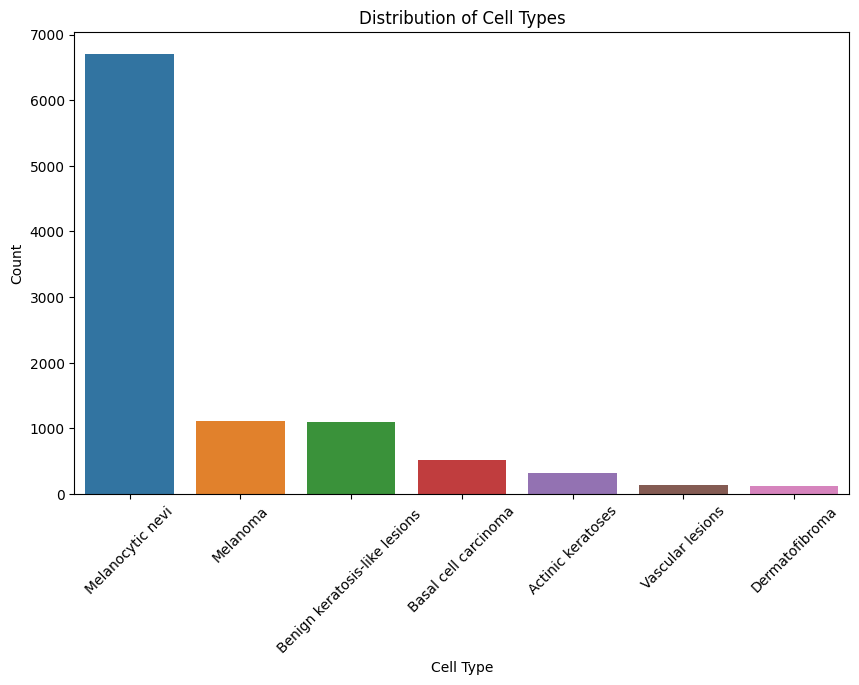

In [12]:
plt.figure(figsize=(10, 6))
sns.countplot(x='cell_type', data=skin_df, order=skin_df['cell_type'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribution of Cell Types')
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.show()

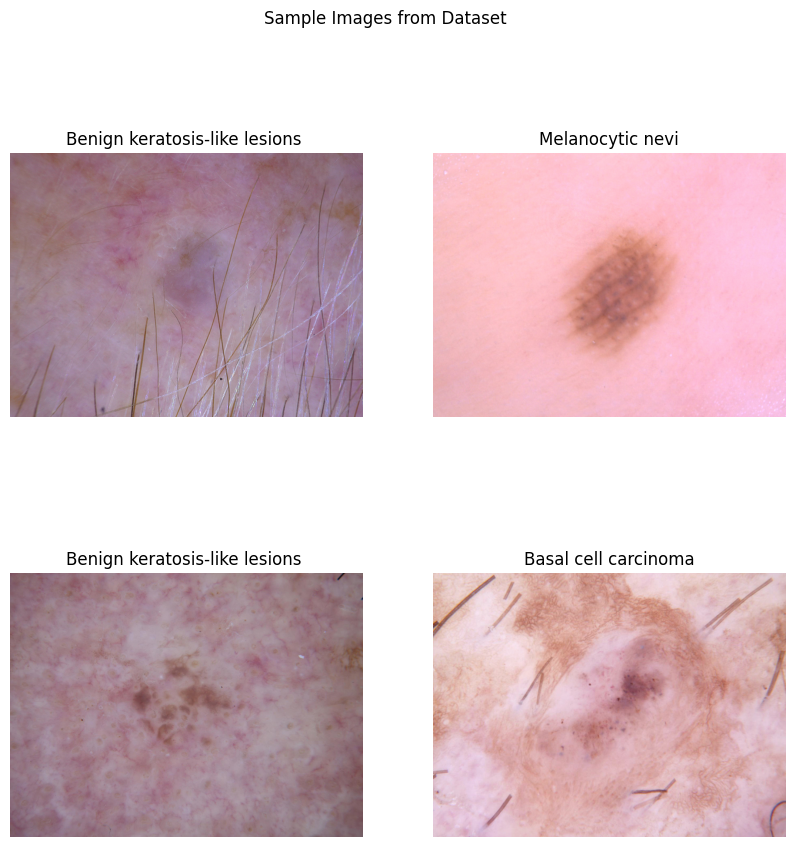

In [ ]:
sample_images = skin_df.sample(9) 
plt.figure(figsize=(10, 10))
for index, row in sample_images.iterrows():
    img = cv2.imread(row['path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 2, index % 4 + 1)
    plt.imshow(img)
    plt.title(row['cell_type'])
    plt.axis('off')
plt.suptitle('Sample Images from Dataset')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


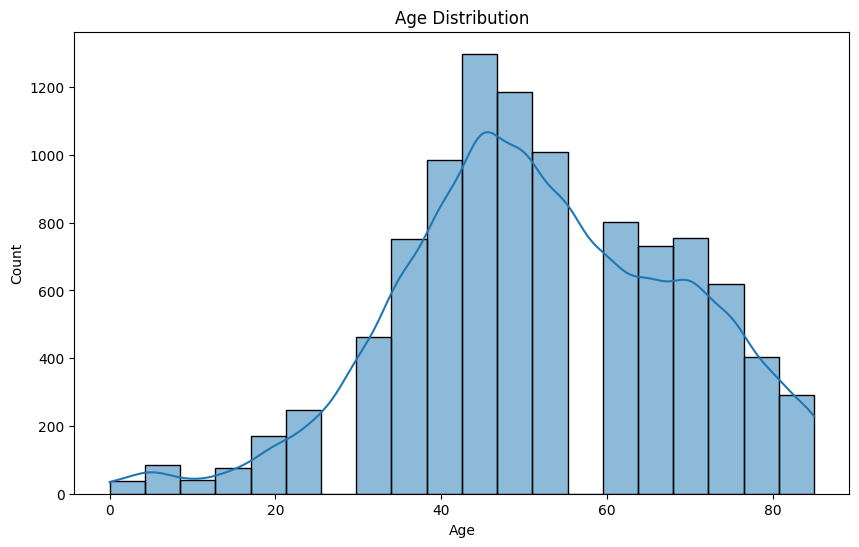

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(df2['age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

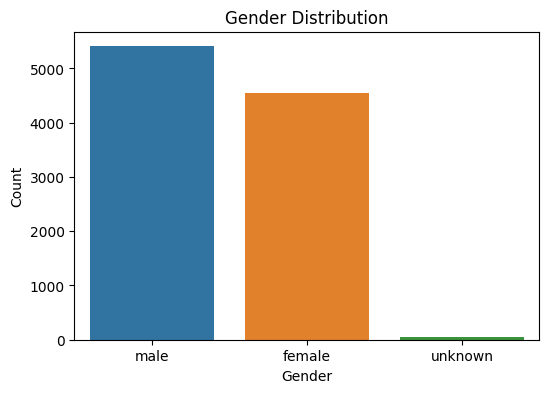

In [15]:
plt.figure(figsize=(6, 4))
sns.countplot(x='sex', data=df2)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

In [16]:
train_dataset = SkinCancerDataset(train_df, transformations)
val_dataset = SkinCancerDataset(valid_df, transformations)
test_dataset = SkinCancerDataset(test_df, transformations)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [17]:
import torchvision.models as models

def load_model(model_name, num_classes):
    if model_name == 'googlenet':
        model = models.googlenet(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'resnet18':
        model = models.resnet18(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'densenet121':
        model = models.densenet121(pretrained=True)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
    else:
        raise ValueError(f'Invalid model name: {model_name}')

    return model.to(device)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(lesion_type_dict)


googlenet = load_model('googlenet', num_classes)
resnet18 = load_model('resnet18', num_classes)
densenet121 = load_model('densenet121', num_classes)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:03<00:00, 13.7MB/s]
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be remo

In [19]:
def train_model(model, train_loader, val_loader, num_epochs=25, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
        
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)
        
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = val_correct.double() / len(val_loader.dataset)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    return model, {'train_losses': train_losses, 'val_losses': val_losses, 'val_accuracies': val_accuracies}

In [20]:
googlenet, googlenet_metrics = train_model(googlenet, train_loader, val_loader)
resnet18, resnet18_metrics = train_model(resnet18, train_loader, val_loader)
densenet121, densenet121_metrics = train_model(densenet121, train_loader, val_loader)

Epoch 1/25: 100%|██████████| 501/501 [02:35<00:00,  3.23it/s]


Epoch 1/25, Train Loss: 0.7942, Val Loss: 0.7092, Val Accuracy: 0.7413


Epoch 2/25: 100%|██████████| 501/501 [01:35<00:00,  5.26it/s]


Epoch 2/25, Train Loss: 0.7018, Val Loss: 0.8179, Val Accuracy: 0.7233


Epoch 3/25: 100%|██████████| 501/501 [01:37<00:00,  5.14it/s]


Epoch 3/25, Train Loss: 0.6509, Val Loss: 0.6683, Val Accuracy: 0.7433


Epoch 4/25: 100%|██████████| 501/501 [01:36<00:00,  5.18it/s]


Epoch 4/25, Train Loss: 0.6205, Val Loss: 0.6729, Val Accuracy: 0.7612


Epoch 5/25: 100%|██████████| 501/501 [01:37<00:00,  5.16it/s]


Epoch 5/25, Train Loss: 0.5750, Val Loss: 0.6696, Val Accuracy: 0.7832


Epoch 6/25: 100%|██████████| 501/501 [01:35<00:00,  5.25it/s]


Epoch 6/25, Train Loss: 0.5279, Val Loss: 0.6500, Val Accuracy: 0.7832


Epoch 7/25: 100%|██████████| 501/501 [01:37<00:00,  5.14it/s]


Epoch 7/25, Train Loss: 0.4953, Val Loss: 0.6538, Val Accuracy: 0.7732


Epoch 8/25: 100%|██████████| 501/501 [01:36<00:00,  5.19it/s]


Epoch 8/25, Train Loss: 0.4511, Val Loss: 0.6657, Val Accuracy: 0.7662


Epoch 9/25: 100%|██████████| 501/501 [01:35<00:00,  5.25it/s]


Epoch 9/25, Train Loss: 0.4047, Val Loss: 0.7872, Val Accuracy: 0.7313


Epoch 10/25: 100%|██████████| 501/501 [01:34<00:00,  5.29it/s]


Epoch 10/25, Train Loss: 0.3665, Val Loss: 0.6435, Val Accuracy: 0.7942


Epoch 11/25: 100%|██████████| 501/501 [01:35<00:00,  5.26it/s]


Epoch 11/25, Train Loss: 0.3079, Val Loss: 0.6767, Val Accuracy: 0.7742


Epoch 12/25: 100%|██████████| 501/501 [01:36<00:00,  5.20it/s]


Epoch 12/25, Train Loss: 0.2738, Val Loss: 0.7000, Val Accuracy: 0.7842


Epoch 13/25: 100%|██████████| 501/501 [01:35<00:00,  5.25it/s]


Epoch 13/25, Train Loss: 0.2336, Val Loss: 0.6662, Val Accuracy: 0.8122


Epoch 14/25: 100%|██████████| 501/501 [01:34<00:00,  5.28it/s]


Epoch 14/25, Train Loss: 0.1877, Val Loss: 0.7084, Val Accuracy: 0.7882


Epoch 15/25: 100%|██████████| 501/501 [01:35<00:00,  5.24it/s]


Epoch 15/25, Train Loss: 0.1688, Val Loss: 1.0801, Val Accuracy: 0.7512


Epoch 16/25: 100%|██████████| 501/501 [01:35<00:00,  5.24it/s]


Epoch 16/25, Train Loss: 0.1412, Val Loss: 0.7612, Val Accuracy: 0.8062


Epoch 17/25: 100%|██████████| 501/501 [01:35<00:00,  5.23it/s]


Epoch 17/25, Train Loss: 0.1286, Val Loss: 0.9346, Val Accuracy: 0.7772


Epoch 18/25: 100%|██████████| 501/501 [01:35<00:00,  5.25it/s]


Epoch 18/25, Train Loss: 0.1138, Val Loss: 0.8867, Val Accuracy: 0.7792


Epoch 19/25: 100%|██████████| 501/501 [01:35<00:00,  5.26it/s]


Epoch 19/25, Train Loss: 0.1242, Val Loss: 0.7649, Val Accuracy: 0.7972


Epoch 20/25: 100%|██████████| 501/501 [01:35<00:00,  5.24it/s]


Epoch 20/25, Train Loss: 0.0983, Val Loss: 0.9455, Val Accuracy: 0.7722


Epoch 21/25: 100%|██████████| 501/501 [01:35<00:00,  5.26it/s]


Epoch 21/25, Train Loss: 0.0847, Val Loss: 0.8242, Val Accuracy: 0.7932


Epoch 22/25: 100%|██████████| 501/501 [01:35<00:00,  5.25it/s]


Epoch 22/25, Train Loss: 0.0954, Val Loss: 0.9225, Val Accuracy: 0.7962


Epoch 23/25: 100%|██████████| 501/501 [01:35<00:00,  5.24it/s]


Epoch 23/25, Train Loss: 0.0778, Val Loss: 0.8146, Val Accuracy: 0.8112


Epoch 24/25: 100%|██████████| 501/501 [01:36<00:00,  5.18it/s]


Epoch 24/25, Train Loss: 0.0845, Val Loss: 0.8927, Val Accuracy: 0.7882


Epoch 25/25: 100%|██████████| 501/501 [01:36<00:00,  5.22it/s]


Epoch 25/25, Train Loss: 0.0572, Val Loss: 1.0590, Val Accuracy: 0.7473


Epoch 1/25: 100%|██████████| 501/501 [01:28<00:00,  5.68it/s]


Epoch 1/25, Train Loss: 0.8927, Val Loss: 0.7752, Val Accuracy: 0.6933


Epoch 2/25: 100%|██████████| 501/501 [01:28<00:00,  5.64it/s]


Epoch 2/25, Train Loss: 0.7599, Val Loss: 0.8181, Val Accuracy: 0.6853


Epoch 3/25: 100%|██████████| 501/501 [01:28<00:00,  5.66it/s]


Epoch 3/25, Train Loss: 0.7061, Val Loss: 0.6980, Val Accuracy: 0.7293


Epoch 4/25: 100%|██████████| 501/501 [01:28<00:00,  5.68it/s]


Epoch 4/25, Train Loss: 0.6719, Val Loss: 0.7550, Val Accuracy: 0.7103


Epoch 5/25: 100%|██████████| 501/501 [01:28<00:00,  5.65it/s]


Epoch 5/25, Train Loss: 0.6389, Val Loss: 0.6451, Val Accuracy: 0.7582


Epoch 6/25: 100%|██████████| 501/501 [01:28<00:00,  5.66it/s]


Epoch 6/25, Train Loss: 0.5949, Val Loss: 0.6793, Val Accuracy: 0.7522


Epoch 7/25: 100%|██████████| 501/501 [01:27<00:00,  5.70it/s]


Epoch 7/25, Train Loss: 0.5543, Val Loss: 0.6924, Val Accuracy: 0.7582


Epoch 8/25: 100%|██████████| 501/501 [01:28<00:00,  5.66it/s]


Epoch 8/25, Train Loss: 0.4948, Val Loss: 0.6458, Val Accuracy: 0.7642


Epoch 9/25: 100%|██████████| 501/501 [01:29<00:00,  5.63it/s]


Epoch 9/25, Train Loss: 0.4275, Val Loss: 0.7404, Val Accuracy: 0.7423


Epoch 10/25: 100%|██████████| 501/501 [01:28<00:00,  5.65it/s]


Epoch 10/25, Train Loss: 0.3412, Val Loss: 0.8064, Val Accuracy: 0.7453


Epoch 11/25: 100%|██████████| 501/501 [01:27<00:00,  5.71it/s]


Epoch 11/25, Train Loss: 0.2552, Val Loss: 0.9420, Val Accuracy: 0.7363


Epoch 12/25: 100%|██████████| 501/501 [01:27<00:00,  5.71it/s]


Epoch 12/25, Train Loss: 0.1777, Val Loss: 0.9639, Val Accuracy: 0.7522


Epoch 13/25: 100%|██████████| 501/501 [01:29<00:00,  5.61it/s]


Epoch 13/25, Train Loss: 0.1209, Val Loss: 1.0235, Val Accuracy: 0.7483


Epoch 14/25: 100%|██████████| 501/501 [01:28<00:00,  5.68it/s]


Epoch 14/25, Train Loss: 0.0943, Val Loss: 1.1015, Val Accuracy: 0.7532


Epoch 15/25: 100%|██████████| 501/501 [01:27<00:00,  5.70it/s]


Epoch 15/25, Train Loss: 0.0919, Val Loss: 1.0229, Val Accuracy: 0.7592


Epoch 16/25: 100%|██████████| 501/501 [01:29<00:00,  5.57it/s]


Epoch 16/25, Train Loss: 0.0754, Val Loss: 1.1403, Val Accuracy: 0.7542


Epoch 17/25: 100%|██████████| 501/501 [01:28<00:00,  5.67it/s]


Epoch 17/25, Train Loss: 0.0839, Val Loss: 1.2592, Val Accuracy: 0.7572


Epoch 18/25: 100%|██████████| 501/501 [01:28<00:00,  5.69it/s]


Epoch 18/25, Train Loss: 0.0513, Val Loss: 1.2441, Val Accuracy: 0.7552


Epoch 19/25: 100%|██████████| 501/501 [01:27<00:00,  5.71it/s]


Epoch 19/25, Train Loss: 0.0648, Val Loss: 1.1572, Val Accuracy: 0.7423


Epoch 20/25: 100%|██████████| 501/501 [01:27<00:00,  5.74it/s]


Epoch 20/25, Train Loss: 0.0800, Val Loss: 1.3770, Val Accuracy: 0.7502


Epoch 21/25: 100%|██████████| 501/501 [01:27<00:00,  5.71it/s]


Epoch 21/25, Train Loss: 0.0381, Val Loss: 1.3675, Val Accuracy: 0.7572


Epoch 22/25: 100%|██████████| 501/501 [01:28<00:00,  5.68it/s]


Epoch 22/25, Train Loss: 0.0399, Val Loss: 1.2953, Val Accuracy: 0.7512


Epoch 23/25: 100%|██████████| 501/501 [01:28<00:00,  5.69it/s]


Epoch 23/25, Train Loss: 0.0510, Val Loss: 1.5505, Val Accuracy: 0.7353


Epoch 24/25: 100%|██████████| 501/501 [01:30<00:00,  5.55it/s]


Epoch 24/25, Train Loss: 0.0381, Val Loss: 1.4283, Val Accuracy: 0.7522


Epoch 25/25: 100%|██████████| 501/501 [01:28<00:00,  5.63it/s]


Epoch 25/25, Train Loss: 0.0602, Val Loss: 1.4544, Val Accuracy: 0.7363


Epoch 1/25: 100%|██████████| 501/501 [02:02<00:00,  4.07it/s]


Epoch 1/25, Train Loss: 0.8315, Val Loss: 0.8068, Val Accuracy: 0.7033


Epoch 2/25: 100%|██████████| 501/501 [02:03<00:00,  4.07it/s]


Epoch 2/25, Train Loss: 0.7217, Val Loss: 0.6776, Val Accuracy: 0.7502


Epoch 3/25: 100%|██████████| 501/501 [02:03<00:00,  4.05it/s]


Epoch 3/25, Train Loss: 0.6690, Val Loss: 0.6755, Val Accuracy: 0.7532


Epoch 4/25: 100%|██████████| 501/501 [02:03<00:00,  4.04it/s]


Epoch 4/25, Train Loss: 0.6263, Val Loss: 0.6600, Val Accuracy: 0.7502


Epoch 5/25: 100%|██████████| 501/501 [02:02<00:00,  4.10it/s]


Epoch 5/25, Train Loss: 0.6010, Val Loss: 0.6372, Val Accuracy: 0.7862


Epoch 6/25: 100%|██████████| 501/501 [02:02<00:00,  4.09it/s]


Epoch 6/25, Train Loss: 0.5776, Val Loss: 0.6227, Val Accuracy: 0.7852


Epoch 7/25: 100%|██████████| 501/501 [02:02<00:00,  4.09it/s]


Epoch 7/25, Train Loss: 0.5503, Val Loss: 0.6330, Val Accuracy: 0.7662


Epoch 8/25: 100%|██████████| 501/501 [02:03<00:00,  4.07it/s]


Epoch 8/25, Train Loss: 0.5088, Val Loss: 0.5700, Val Accuracy: 0.7952


Epoch 9/25: 100%|██████████| 501/501 [02:02<00:00,  4.08it/s]


Epoch 9/25, Train Loss: 0.4789, Val Loss: 0.5951, Val Accuracy: 0.7822


Epoch 10/25: 100%|██████████| 501/501 [02:03<00:00,  4.07it/s]


Epoch 10/25, Train Loss: 0.4495, Val Loss: 0.5966, Val Accuracy: 0.7952


Epoch 11/25: 100%|██████████| 501/501 [02:01<00:00,  4.12it/s]


Epoch 11/25, Train Loss: 0.4207, Val Loss: 0.6453, Val Accuracy: 0.7832


Epoch 12/25: 100%|██████████| 501/501 [02:04<00:00,  4.02it/s]


Epoch 12/25, Train Loss: 0.3747, Val Loss: 0.6831, Val Accuracy: 0.7912


Epoch 13/25: 100%|██████████| 501/501 [02:02<00:00,  4.09it/s]


Epoch 13/25, Train Loss: 0.3365, Val Loss: 0.5511, Val Accuracy: 0.8072


Epoch 14/25: 100%|██████████| 501/501 [02:02<00:00,  4.10it/s]


Epoch 14/25, Train Loss: 0.3251, Val Loss: 0.5650, Val Accuracy: 0.8062


Epoch 15/25: 100%|██████████| 501/501 [02:02<00:00,  4.10it/s]


Epoch 15/25, Train Loss: 0.2763, Val Loss: 0.6457, Val Accuracy: 0.7982


Epoch 16/25: 100%|██████████| 501/501 [02:02<00:00,  4.09it/s]


Epoch 16/25, Train Loss: 0.2418, Val Loss: 0.6644, Val Accuracy: 0.7752


Epoch 17/25: 100%|██████████| 501/501 [02:03<00:00,  4.07it/s]


Epoch 17/25, Train Loss: 0.2044, Val Loss: 0.6173, Val Accuracy: 0.7912


Epoch 18/25: 100%|██████████| 501/501 [02:02<00:00,  4.09it/s]


Epoch 18/25, Train Loss: 0.1694, Val Loss: 0.6965, Val Accuracy: 0.7812


Epoch 19/25: 100%|██████████| 501/501 [02:03<00:00,  4.05it/s]


Epoch 19/25, Train Loss: 0.1535, Val Loss: 0.7849, Val Accuracy: 0.8002


Epoch 20/25: 100%|██████████| 501/501 [02:02<00:00,  4.08it/s]


Epoch 20/25, Train Loss: 0.1403, Val Loss: 0.7667, Val Accuracy: 0.7902


Epoch 21/25: 100%|██████████| 501/501 [02:02<00:00,  4.08it/s]


Epoch 21/25, Train Loss: 0.1137, Val Loss: 0.8633, Val Accuracy: 0.7992


Epoch 22/25: 100%|██████████| 501/501 [02:01<00:00,  4.11it/s]


Epoch 22/25, Train Loss: 0.1419, Val Loss: 0.7635, Val Accuracy: 0.7872


Epoch 23/25: 100%|██████████| 501/501 [02:02<00:00,  4.08it/s]


Epoch 23/25, Train Loss: 0.1151, Val Loss: 0.7922, Val Accuracy: 0.8062


Epoch 24/25: 100%|██████████| 501/501 [02:02<00:00,  4.08it/s]


Epoch 24/25, Train Loss: 0.0781, Val Loss: 0.8109, Val Accuracy: 0.8042


Epoch 25/25: 100%|██████████| 501/501 [02:02<00:00,  4.09it/s]


Epoch 25/25, Train Loss: 0.0831, Val Loss: 0.9135, Val Accuracy: 0.7992


In [21]:
def compute_weights(*models_metrics):
    weights = []
    for metrics in models_metrics:
        weight = 1.0 / metrics['val_accuracies'][-1]
        weights.append(weight)
    
    total = sum(weights)
    normalized_weights = [w / total for w in weights]
    
    return normalized_weights

In [22]:
def ensemble_predictions(data_loader, *models, weights):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ensemble_preds = []
    
    for inputs, _ in tqdm(data_loader, desc="Generating Ensemble Predictions"):
        inputs = inputs.to(device)
        preds = torch.zeros(inputs.size(0), len(models)).to(device)
        
        for i, model in enumerate(models):
            model.eval()
            with torch.no_grad():
                outputs = model(inputs)
                preds[:, i] = outputs.argmax(dim=1)
        
        weighted_preds = torch.sum(preds * torch.tensor(weights).to(device), dim=1)
        ensemble_preds.extend(weighted_preds.tolist())
    
    return ensemble_preds

In [23]:
weights = compute_weights(googlenet_metrics, resnet18_metrics, densenet121_metrics)

ensemble_preds = ensemble_predictions(val_loader, googlenet, resnet18, densenet121, weights=weights)

Generating Ensemble Predictions: 100%|██████████| 63/63 [00:12<00:00,  4.92it/s]


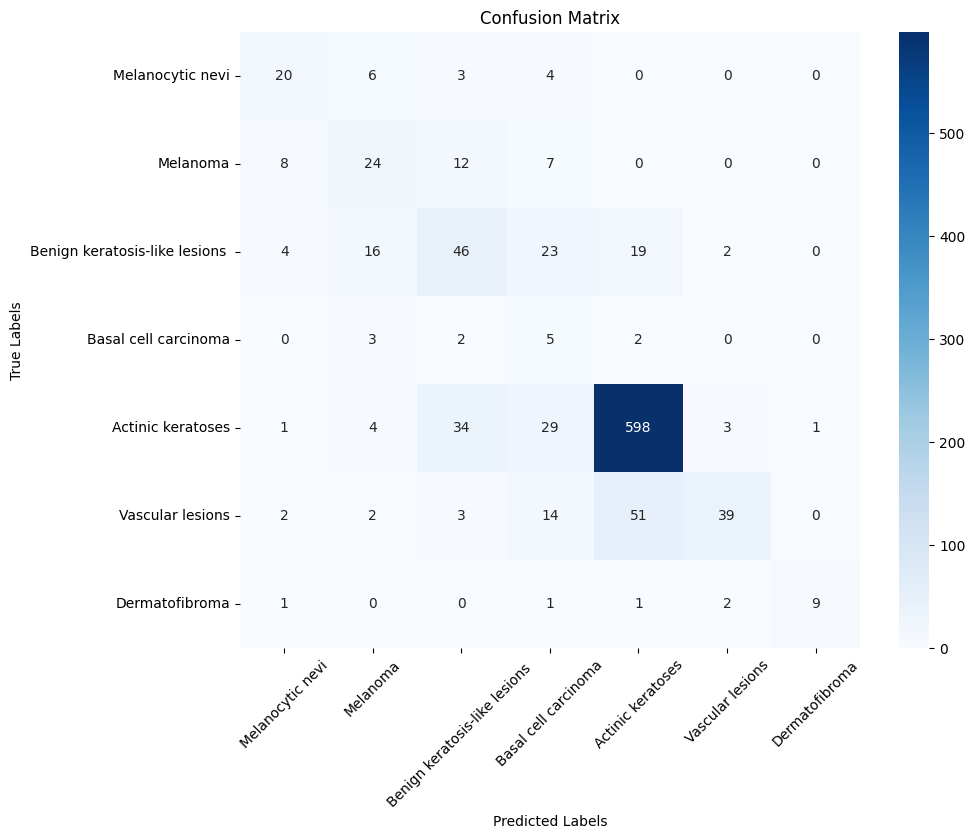

In [32]:
true_labels = valid_df['labels'].astype(int).tolist()

ensemble_preds_int = [int(pred) for pred in ensemble_preds]

cm = confusion_matrix(true_labels, ensemble_preds_int)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lesion_type_dict.values(), yticklabels=lesion_type_dict.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [33]:
class_report = classification_report(true_labels, ensemble_preds_int, target_names=lesion_type_dict.values())
print(class_report)

                                precision    recall  f1-score   support

              Melanocytic nevi       0.56      0.61      0.58        33
                      Melanoma       0.44      0.47      0.45        51
Benign keratosis-like lesions        0.46      0.42      0.44       110
          Basal cell carcinoma       0.06      0.42      0.11        12
             Actinic keratoses       0.89      0.89      0.89       670
              Vascular lesions       0.85      0.35      0.50       111
                Dermatofibroma       0.90      0.64      0.75        14

                      accuracy                           0.74      1001
                     macro avg       0.59      0.54      0.53      1001
                  weighted avg       0.79      0.74      0.75      1001



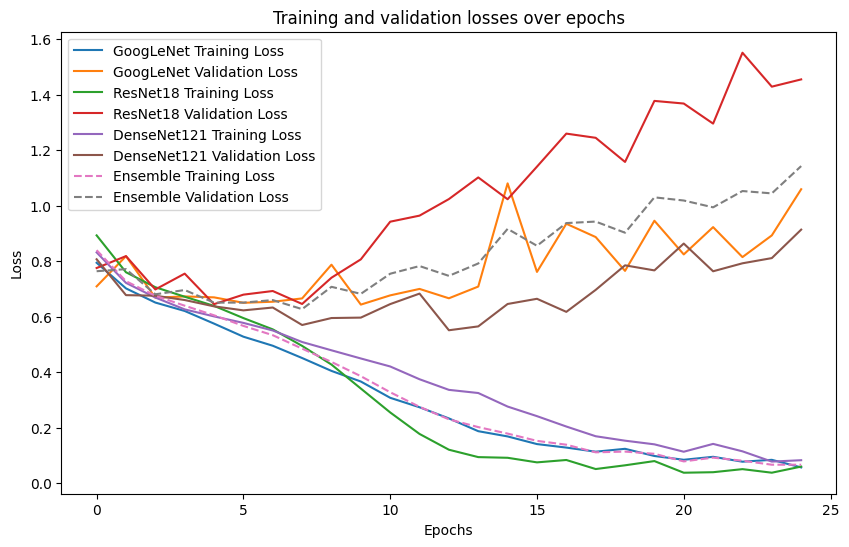

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(googlenet_metrics['train_losses'], label='GoogLeNet Training Loss')
plt.plot(googlenet_metrics['val_losses'], label='GoogLeNet Validation Loss')
plt.plot(resnet18_metrics['train_losses'], label='ResNet18 Training Loss')
plt.plot(resnet18_metrics['val_losses'], label='ResNet18 Validation Loss')
plt.plot(densenet121_metrics['train_losses'], label='DenseNet121 Training Loss')
plt.plot(densenet121_metrics['val_losses'], label='DenseNet121 Validation Loss')

# Ensemble curve
ensemble_train_losses = [
    (googlenet_metrics['train_losses'][i] + resnet18_metrics['train_losses'][i] + densenet121_metrics['train_losses'][i]) / 3
    for i in range(len(googlenet_metrics['train_losses']))
]
ensemble_val_losses = [
    (googlenet_metrics['val_losses'][i] + resnet18_metrics['val_losses'][i] + densenet121_metrics['val_losses'][i]) / 3
    for i in range(len(googlenet_metrics['val_losses']))
]
plt.plot(ensemble_train_losses, label='Ensemble Training Loss', linestyle='--')
plt.plot(ensemble_val_losses, label='Ensemble Validation Loss', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation losses over epochs')
plt.legend()
plt.show()